In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pynvcenter.nv_analysis as nv_analysis

from sklearn.externals import joblib

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from sklearn.externals import joblib
import h5py
from keras import regularizers

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm

import h5py
%load_ext autoreload
%autoreload 2
from keras.models import load_model

Using TensorFlow backend.


In [2]:
tag = 'shot_noise_2'  # tage for the trained model that we use to fit the data

model = load_model('../models/'+tag+'_model.h5')

### show the experimental data
#### define inputs (filenames, calibration, etc.)

In [58]:
filename_esr = '../data/190110-13_35_16_esr_many_ring_esr_map.h5'
filename_pos = '../data/190110-12_04_46_select_points-nv_locations.csv'
calibration_factor = 200/162 * 267 / 0.5  # mu / px * px / V = mu / V

particle_radius = 19  # um

print('the calibration factor is {:0.3f} micrometers / volt'.format(calibration_factor))

h5f = h5py.File(filename_esr, 'r')
esr_map = np.array(h5f['esr_map'])
frequencies = np.array(h5f['frequency'])
h5f.close()

the calibration factor is 659.259 micrometers / volt


the radius is 73.670 micrometers


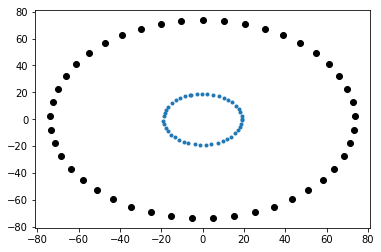

In [60]:
nv_positions = calibration_factor * np.genfromtxt(filename_pos, delimiter=',')[1:]  # positions in um
nv_positions -=np.mean(nv_positions, axis=0)  # center around zero 
for pos in nv_positions:
    plt.plot(pos[0], pos[1], 'ko')
    
angles = np.linspace(0, 360, esr_map.shape[0])
plt.plot(particle_radius*np.cos(angles), particle_radius*np.sin(angles), '.')
    

radius  = np.mean(np.sqrt(np.sum(nv_positions**2, axis=1)))
print('the radius is {:0.3f} micrometers'.format(radius))

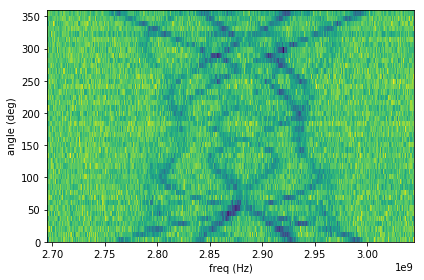

In [24]:
angles = np.linspace(0, 360, esr_map.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.pcolor(frequencies, angles, esr_map)

ax.set_ylabel('angle (deg)')
ax.set_xlabel('freq (Hz)')
# ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
plt.tight_layout()

The noise is $n = \sqrt{c \tau}$, where $s = c \tau$ are the number of photons collected. Thus, the normalized noise is

$$n_{\rm norm} = n/s =  1 / \sqrt{c \tau}$$,

where $c$ is the count rate and $\tau$ the measurement time.

the noise level is 0.0018. Thus for count rate 1000, the measurement time is 298


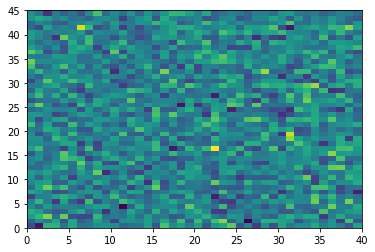

In [77]:
noise = np.std(esr_map[:, 0:40])

plt.pcolor(esr_map[:, 0:40])
print('the noise level is {:0.4f}. Thus for count rate 1000, the measurement time is {:0.0f}'.format(noise, 1/(1000*noise**2)))

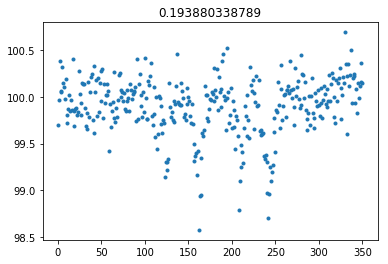

In [87]:
for i in [30]:
    plt.plot(esr_map[i]*100,'.')
    plt.title(np.std(esr_map[i, 0:30]*100))

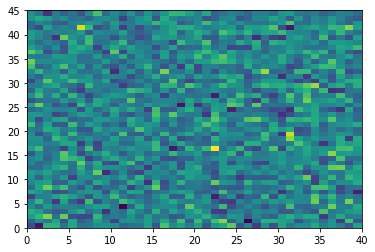

In [68]:
frequencies[0:50]

array([  2.69500000e+09,   2.69600000e+09,   2.69700000e+09,
         2.69800000e+09,   2.69900000e+09,   2.70000000e+09,
         2.70100000e+09,   2.70200000e+09,   2.70300000e+09,
         2.70400000e+09,   2.70500000e+09,   2.70600000e+09,
         2.70700000e+09,   2.70800000e+09,   2.70900000e+09,
         2.71000000e+09,   2.71100000e+09,   2.71200000e+09,
         2.71300000e+09,   2.71400000e+09,   2.71500000e+09,
         2.71600000e+09,   2.71700000e+09,   2.71800000e+09,
         2.71900000e+09,   2.72000000e+09,   2.72100000e+09,
         2.72200000e+09,   2.72300000e+09,   2.72400000e+09,
         2.72500000e+09,   2.72600000e+09,   2.72700000e+09,
         2.72800000e+09,   2.72900000e+09,   2.73000000e+09,
         2.73100000e+09,   2.73200000e+09,   2.73300000e+09,
         2.73400000e+09,   2.73500000e+09,   2.73600000e+09,
         2.73700000e+09,   2.73800000e+09,   2.73900000e+09,
         2.74000000e+09,   2.74100000e+09,   2.74200000e+09,
         2.74300000e+09,